# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline

## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
# train test split!
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

# In this section I standardize the training data first by doing scaler.fit(xtrain), I then transform both the train and the test with this to ensure I do not allow test information to leak into training and to make sure training rules are being applied to the test set. I opt for standardization because some gene expressions have outliers and these may be significant in later stages of the modeling (normalizing may scale down my predictors to very small numbers if I have large outliers) 

In [23]:
# scaling entire dataset/train and test
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
newXtrain = pd.DataFrame.copy(data_train.loc[:,data_train.columns!='Cancer_type'])
scaler.fit(newXtrain)
Xtrain_scaled = pd.DataFrame(scaler.transform(newXtrain), columns=newXtrain.columns)
Xtrain_scaled=Xtrain_scaled.set_index(data_train.index)
Xtrain_scaled['Cancer_type'] = pd.DataFrame.copy(data_train['Cancer_type'])
newXtest = pd.DataFrame.copy(data_test.loc[:,data_test.columns!='Cancer_type'])
Xtest_scaled = pd.DataFrame(scaler.transform(newXtest), columns=newXtest.columns)
Xtest_scaled=Xtest_scaled.set_index(data_test.index)
Xtest_scaled['Cancer_type'] = pd.DataFrame.copy(data_test['Cancer_type'])

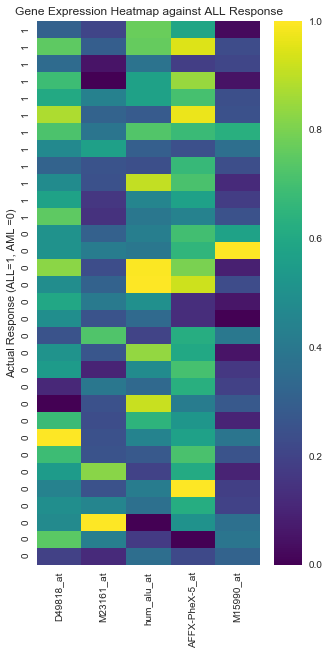

In [24]:
# plot heatmap using seaborn (much easier)
import seaborn as sns
zz = Xtrain_scaled.sort_values(by='Cancer_type', ascending=0)
fig, ax = plt.subplots(figsize=(5,10))
ax = sns.heatmap(zz[['D49818_at','M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at']],cmap ='viridis')
ax.set_yticklabels(reversed(zz[['Cancer_type']].values[:,0]))
plt.title('Gene Expression Heatmap against ALL Response')
plt.ylabel('Actual Response (ALL=1, AML =0)')

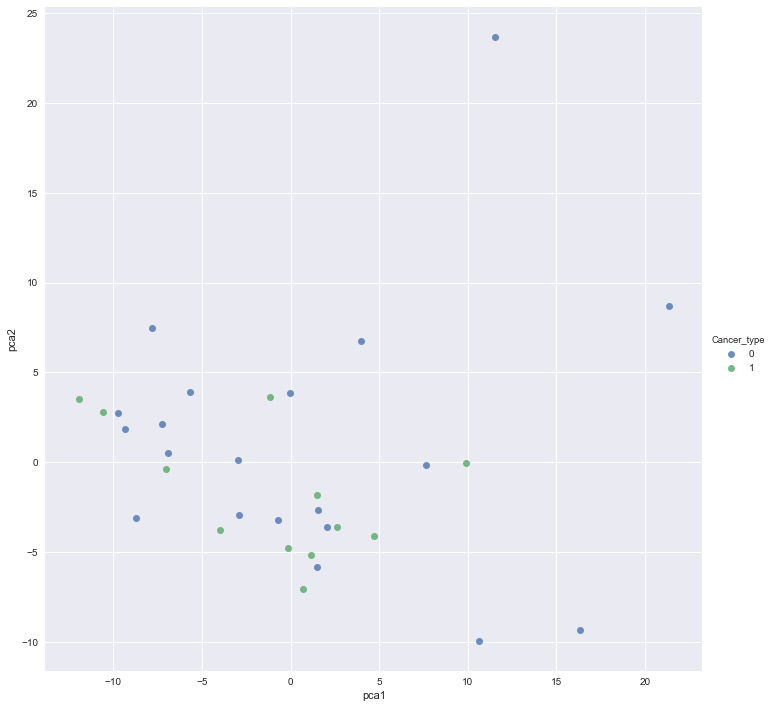

In [25]:
# PCA section
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
respca = pca.fit_transform(zz.drop('Cancer_type',axis =1))
respca = pd.DataFrame(respca, columns = ['pca1','pca2'])
respca['Cancer_type'] = zz[['Cancer_type']].values
sns.lmplot(x = 'pca1',y='pca2',data = respca,hue = 'Cancer_type',fit_reg = False,size = 10)

Q

- Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

A

- Yes, high probability of over fitting our data (hence high likelihood of large variance e.g. low test score and high training score where score refers to (1-misclassification rate)) 

Q

- A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes:  D49818_at, M23161_at, hum_alu_at, AFFX-PheX-5_at, M15990_at. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.
    
A

- Out of interest, I ran the model using standardization and normalization and the only core difference between these models was the heatmap generated in this section. Therefore,  it depends on the way you standardize/normalize data. When you $\textbf{normalize}$ the data 'M15990_at' and 'M23161_at' are dark almost everywhere so we do not think these two can be good predictors. The others don't seem to have clear demarcations but AFXX seems to be relatively good with darker regions with zeros and lighter with 1's.
- When we $\textbf{standardize}$, M23161_at gives us lighter yellows for 0 and darker colors for 1's meaning this could be a good predictor. 
- Why this difference you ask? Well, we get this difference because when we scale with min max, we really are scaling by outliers in our data therefore, many of the points are being divided by these outliers. For the rest of the problem I have used standardization. 

Q

- How do top 2 PCA components discriminate between 2 classes

A

- Top 2 pca components can discriminate a decent number of types. For example, in the lower left half (so low pca1 and pca2 values) we tend to get green dots and hence ALL. In the region to the top right of this, we generally get most of the blue dots with some level of misclassification. Therefore, 2 pca components aren't bad at prediction. We will see in a later section that this is quite true.

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `M23161_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [26]:
# part 1
# extract train and test response
ytrain = Xtrain_scaled[['Cancer_type']].values
ytest = Xtest_scaled[['Cancer_type']].values
# fit a linear regression
linreg = LinearRegression(fit_intercept = True)
linreg.fit(Xtrain_scaled[['D29963_at']],ytrain)
ypred = linreg.predict(Xtrain_scaled[['D29963_at']])
df = pd.DataFrame(np.c_[ypred,ytrain], columns = ['predicted%of1','actual'])
df.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
predicted%of1,0.323413,0.208606,0.394713,0.430968,0.398339,0.329455,0.396325,0.328649,0.439025,0.327038,...,0.349597,0.186451,0.882137,0.508311,0.374169,0.518785,0.298437,0.368932,0.20055,0.593309
actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [27]:
# use values as %'s and cast to 1's and 0's with 0.5 
ypred = ypred[:,0]
ypred[ypred>0.5] = 1
ypred[ypred<=0.5] = 0
print('Train Classification accuracy (linear) =%s' %(1-np.sum(abs(ypred-ytrain[:,0]))/len(ypred)))
ypred = linreg.predict(Xtest_scaled[['D29963_at']])
ypred = ypred[:,0]
ypred[ypred>0.5] = 1
ypred[ypred<=0.5] = 0
print('Test Classification accuracy (linear) =%s' %(1-np.sum(abs(ypred-ytest[:,0]))/len(ypred)))

Train Classification accuracy (linear) =0.71875
Test Classification accuracy (linear) =0.829268292683


In [28]:
# fit logistic regression to gene expre d29963
logreg = LogisticRegression(fit_intercept = True, C = 100000)
logreg.fit(Xtrain_scaled[['D29963_at']],np.ravel(ytrain))
ypred = logreg.predict(Xtrain_scaled[['D29963_at']])
print('Train Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytrain[:,0]))/len(ypred)))
ypred = logreg.predict(Xtest_scaled[['D29963_at']])
print('Test Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytest[:,0]))/len(ypred)))

Train Classification accuracy (logistic) =0.71875
Test Classification accuracy (logistic) =0.829268292683


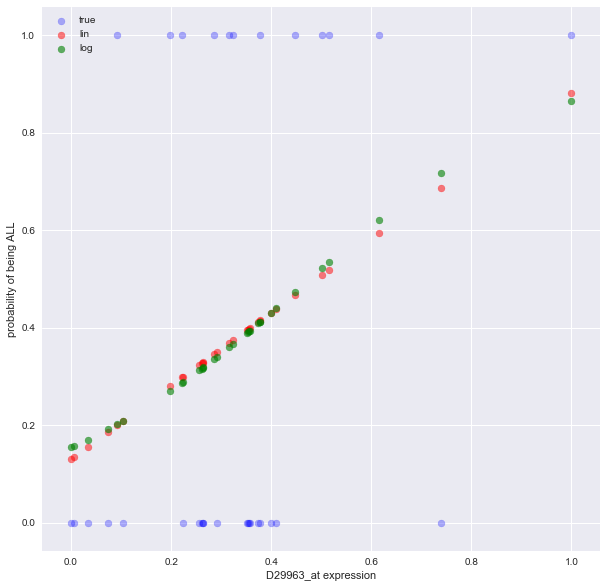

In [29]:
# plot probabilities of log and linear regression with True response
xvals = Xtrain_scaled[['D29963_at']]
ypredlin = linreg.predict(Xtrain_scaled[['D29963_at']])
ypredlog = logreg.predict_proba(Xtrain_scaled[['D29963_at']])
ytrue = Xtrain_scaled[['Cancer_type']]
plt.figure(figsize=(10,10))
plt.scatter(xvals,ytrue,label = 'true', c = 'b',alpha = 0.3)
plt.scatter(xvals,ypredlin,label = 'lin',c = 'r',alpha = 0.5)
plt.scatter(xvals,ypredlog[:,1],label = 'log',c='g',alpha = 0.6)
plt.xlabel('D29963_at expression')
plt.ylabel('probability of being ALL')
plt.legend()

Q

- Fit a simple linear regression model to the training set using the single gene predictor D29963_at. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the ALL type cancer (class 1). Is there a problem with this interpretation?

A

- Our model is not restricted in any way to be between 0 and 1, we could have negative predictions or predictions greater than 1 which are obviously not probabilities so while this interpretation allows us to classify we may not generate probabilities. Furthermore, if we had more classification regions, then our predictions can definitely not be interpreted in this way since our response could be in any range (depending on values of response variables).


Q

- How does the training and test calssification accuracy of this model compare with the linear regression model?

A

- We can see from the results above that both models generate the same train and test scores. At first instance this seems odd since we were introduced with the notion that logistic regression is a classifier (and should do better) but when we dig deeper we can see that because the gene expression values aren't highly spread (e.g low expression values don't lead to 0's while high expression values don't lead to 1's) these two methods are comparable. A great source explaining the similarities can be found here: https://statisticalhorizons.com/linear-vs-logistic . Essentially, linear regression can often times do just as well if the probabilities don't have much spread and hence the log odds are linear.

Q

- Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

A

- In the center we can see there is similar performance but at the extrema, it depends so from this particular example neither model is 'better' at first glance. However, if the expression values were more spread out, logistic regression would be better since it can do better at boundaries if there is enough spread in expression. This goes back to the discussion listed in the answer to the previous question. 

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [30]:
# fit to all predictors
colz = Xtrain_scaled.columns[:-1] 
xtrain = Xtrain_scaled[colz]
xtest = Xtest_scaled[colz]
multilr = LogisticRegression(fit_intercept = True,C = 10**6)
multilr.fit(xtrain,np.ravel(ytrain))
ypred = multilr.predict(xtrain)
print('Train Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytrain[:,0]))/len(ypred)))
ypred = multilr.predict(xtest)
print('Test Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytest[:,0]))/len(ypred)))



Train Classification accuracy (logistic) =1.0
Test Classification accuracy (logistic) =0.975609756098


In [31]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'ALL')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'AML')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of ALL class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])


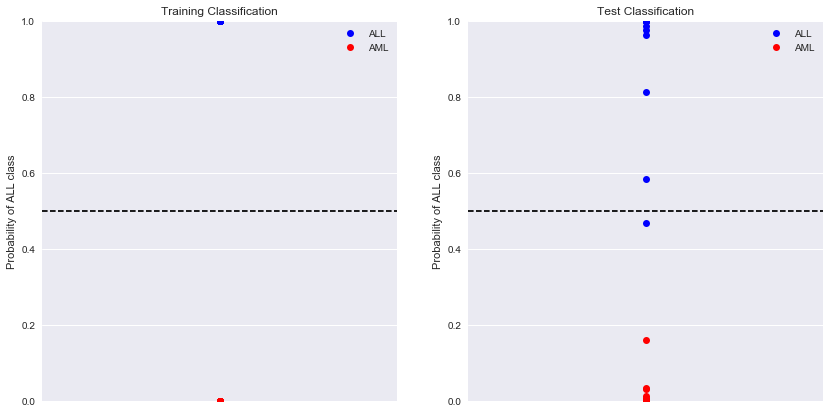

In [32]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
visualize_prob(multilr,xtrain,np.ravel(ytrain),ax[0])
ax[0].set_title('Training Classification')
visualize_prob(multilr,xtest,np.ravel(ytest),ax[1])
ax[1].set_title('Test Classification')

Q

- Next, fit a multiple logistic regression model with all the gene predictors from the data set. How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?

A

- Classification accuracy on both training and test set improves with classification on the training set moving to 100% accuracy (indicative of some level of overfitting). The test score improves from 0.829 to 0.97 suggesting that the increase in feature space adds some more complexity and improves our test score.

Q

- "Use the visualize_prob from HW5_functions.py to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the ALL and AML classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

A

- There is a difference in the spread of probabilities of training and test. In the test we can see a wider range of probabilities since our model is over fitting and is not handling 'unseen' data as well as the training. We can also see some misclassification due to this as we can see some values which are truly ALL being predicted with probabilities less than 0.5.

There aren't any points close to 0.5 using standardization but when I ran this with normalization I did find some points close to 0.5. In that case it seems like those points have an equal likelihood of being classed into AML or ALL even though they are distinctly one type. Therefore, we may want to consider how we could potentially change this probability if we cared about increased accuracy of ALL vs AML for example.

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [33]:
coefsig =[]

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)


multilr = LogisticRegression(fit_intercept = True,C = 10**6)
from random import randint
for i in range(100):
    xx, yy = sample(xtrain.values,ytrain,32)
    
    multilr.fit(xx,np.ravel(yy))
    coefsig.append(multilr.coef_)

In [34]:
coefsig = np.array(coefsig)

avgcoef = np.mean(coefsig,axis = 0)[0,:]
stdcoef = np.std(coefsig,axis = 0)[0,:]
z2 = avgcoef-2*stdcoef
z1 = avgcoef+2*stdcoef
print('Number of Statistically significant values:%s' %(np.shape(z2[z2>0])[0] + np.shape(z1[z1<0])[0]))

Number of Statistically significant values:1717


- In running the bootstrapping scheme we make no assumptions about our data, however it is possible that there is correlation between our data. So in many cases a t-test is not identical to a 95% confidence interval from bootstrapping. However, for the purpose of this problem we assume we can use this method. Therefore we bootstrap 100 times, take the mean and look at 2 standard deviations, if the value zero appears then the coefficient is not statistically significant. What we find is that 1100 coefficients are statistically significant at this confidence level. If I normalize the data in step 1, I find that number of significant coefficients is 1690. This already can be used to help us narrow down our feature space.

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


In [35]:
pcavar = []
i = 1
while True:
    pca = PCA(n_components = i)
    pca.fit(xtrain)
    pcavar.append(pca.explained_variance_ratio_.sum())
    if (pca.explained_variance_ratio_.sum()) >= 0.9:
        break
    i+=1

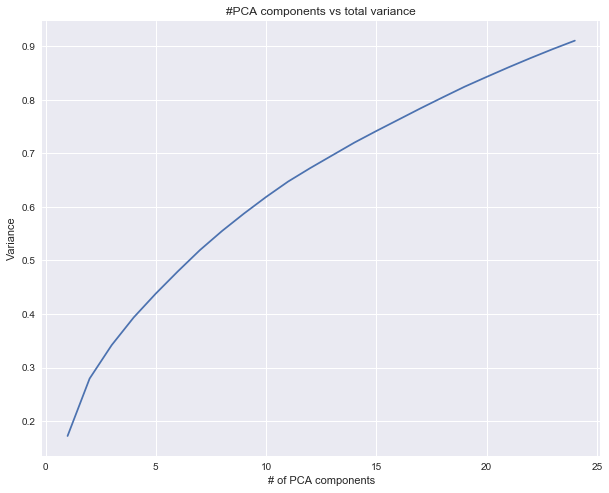

In [36]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1,25,1),pcavar)
plt.title('#PCA components vs total variance')
plt.ylabel('Variance')
plt.xlabel('# of PCA components')

I choose 24 pca compoonents since it contributes to 91% of the variance

In [37]:
multilr = LogisticRegression(fit_intercept = True, C = 10**6)
pca = PCA(n_components = 24)
pca.fit(xtrain)
xpca = pca.transform(xtrain)
xtst = pca.transform(xtest)
multilr.fit(xpca,np.ravel(ytrain))

ypred = multilr.predict(xpca)
print('Train Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytrain[:,0]))/len(ypred)))
ypred = multilr.predict(xtst)
print('Test Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytest[:,0]))/len(ypred)))


Train Classification accuracy (logistic) =1.0
Test Classification accuracy (logistic) =0.926829268293


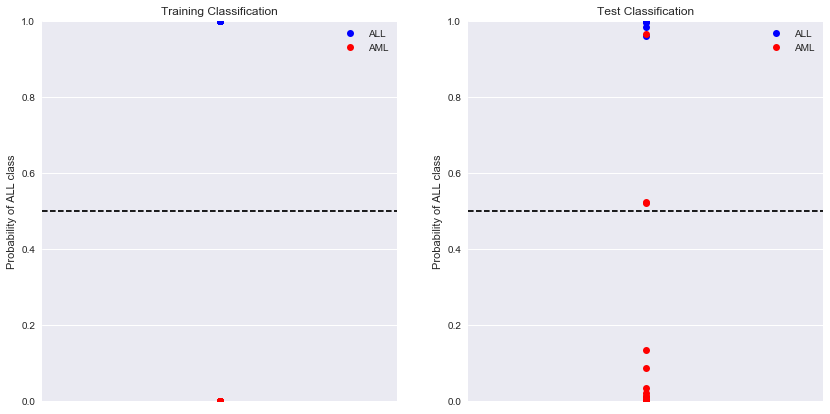

In [38]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
visualize_prob(multilr,xpca,np.ravel(ytrain),ax[0])
ax[0].set_title('Training Classification')
visualize_prob(multilr,xtst,np.ravel(ytest),ax[1])
ax[1].set_title('Test Classification')


In [39]:
lrcv = LogisticRegressionCV(Cs = [10**8],fit_intercept = True,cv = 5)
scores = []
stds = []
for i in range(23):
    lrcv.fit(xpca[:,0:i+1],np.ravel(ytrain))
    scores.append(lrcv.scores_)

In [40]:
scores = np.array(scores)
lrcv_means = [np.mean(scores[i][1]) for i in range(23)]
stds = [np.std(scores[i][1]) for i in range(23)]
xx = np.arange(1,24,1)

<Container object of 3 artists>

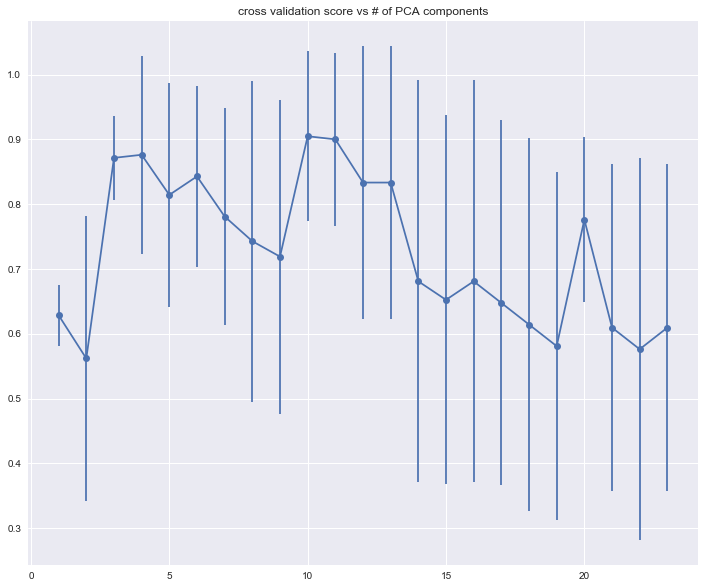

In [41]:
plt.figure(figsize=(12,10))
plt.title('cross validation score vs # of PCA components')
plt.errorbar(xx,lrcv_means,yerr = stds,marker='o',linestyle=None)

In [239]:
np.argmax(lrcv_means) +1

4

4 features yield the highest training accuracy

In [240]:
multilr = LogisticRegression(fit_intercept = True, C = 10**6)
multilr.fit(xpca[:,0:4],np.ravel(ytrain))

ypred = multilr.predict(xpca[:,0:4])
print('Train Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytrain[:,0]))/len(ypred)))
ypred = multilr.predict(xtst[:,0:4])
print('Test Classification accuracy (logistic) =%s' %(1-np.sum(abs(ypred-ytest[:,0]))/len(ypred)))


Train Classification accuracy (logistic) =0.9375
Test Classification accuracy (logistic) =0.853658536585


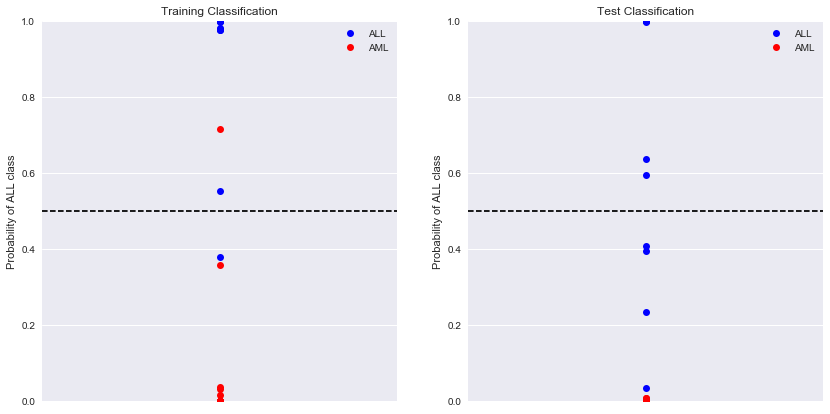

In [241]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
visualize_prob(multilr,xpca[:,0:4],np.ravel(ytrain),ax[0])
ax[0].set_title('Training Classification')
visualize_prob(multilr,xtst[:,0:4],np.ravel(ytest),ax[1])
ax[1].set_title('Test Classification')


Q

- How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?

A

- I think you meant parts (b) and (c) above therefore:
- Classification accuracy with 24 PCA components on training is equivalent to multiple logistic regression (= 1) which are both higher than linear and logistic regression with 1 feature (~ 0.7).
- Classification accuracy on test is lower than multiple logistic regression (~0.92 < 0.97). However, with only 24 features we can do roughly just as well as 7129! which is great if we can afford some level of misclassification and we care about faster results(assuming we have a lot of data to parse and computational complexity grows with the number of features). Both these models (24PCA features and multiple logistic) do better than the single feature we had in part b.

Q

- Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations).

A

- We carry out the above step because there may be an optimal subset of the 24 components that gives us a good cross validation score which could allow us to down select our features even more (since there may be overfitting with a train score of 1). We obtain a lower train score as expected since we are reducing over fitting by optimizing our model on the cross validation set. We obtain lower test performance than the 24 features with 4 principal components and this may be because we give up some complexity in the down selection process. Furthermore, because we have very few observations, our cross validation step shows us that there is a large variance in the cross validation score meaning that 4 features may not be the optimal subset since we could have just gotten lucky. Therefore, in this situation, having more data is very useful. This issue of few data points also means that while we can fit well to our training set, our test set may have many outliers which the model with 4 features is unable to account for (while the model with 24 is!).

Q

- Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)?

A

- More spread in the training set with 4PCA components than with 24 since we have fewer features and the training accuracy is lower - we can thus see some misclassification with blue dots below the 0.5 line. In the test set we see a great degree of misclassification by 4 PCA components, with less spread indicated by 24 PCA components and multiple regression. What we can synthesize from this is that models which are more complex seem to predict with less spread in probabilities in that they are more 'decisive' so to speak. While fewer features predict with greater spread.

---
 

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?